In [1]:
import numpy as np 
import pandas 
import os
import re
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
pandas.set_option('max_colwidth', None)
datadir = '/home/idies/workspace/getting_started/bigdata/baseball/seasons/'
print('ok')

ok


In [2]:
events_df = pandas.DataFrame()
events_by_season_files = sorted([datadir+x for x in os.listdir(datadir) if ('.csv' in x)])
events_by_season_files
for thisfile in events_by_season_files[-1:]:
    print('Reading events in the {0:} season...'.format(int(thisfile[-10:-6])))
    events_df = pandas.concat((events_df, pandas.read_csv(thisfile, low_memory=False, index_col='eventID')))
print('backing up...')
events_df_bk = events_df
print('ok')

Reading events in the 2022 season...
backing up...
ok


In [3]:
print('getting from backup...')
events_df = events_df_bk
events_df = events_df.assign(parsed = False)
events_df = events_df.assign(event_type = np.nan)

print('parsing events...')
events_df.loc[(events_df['theplay'] == 'NP') & (~events_df['parsed']), ['parsed', 'event_type']] = [True, 'No play']
events_df.loc[(events_df['theplay'].apply(lambda x: str(x)[0:2] in ['SB', 'CS', 'PO', 'WP', 'PB', 'DI', 'OA', 'BK'])) & (~events_df['parsed']), ['parsed', 'event_type']] = [True, 'Non-batter event']
events_df.loc[events_df['theplay'].apply(lambda x: x[0] == 'K')  & (~events_df['parsed']), ['parsed', 'event_type']] = [True, 'Strikeout']
events_df.loc[events_df['theplay'].apply(lambda x: (x[0] == 'W') | (x[0:2] == 'IW') | (x[0:2] == 'HP') | (x[0] == 'C'))  & (~events_df['parsed']), ['parsed', 'event_type']] = [True, 'Walk']

events_df.loc[events_df['theplay'].apply(lambda x: x[0:2] == 'HR')  & (~events_df['parsed']), ['parsed', 'event_type']] = [True, 'Home run']
events_df.loc[events_df['theplay'].apply(lambda x: (x[0] == 'E') | (x[0:3] == 'FLE'))  & (~events_df['parsed']), ['parsed', 'event_type']] = [True, 'Error']
events_df.loc[events_df['theplay'].apply(lambda x: x[0:2] == 'FC')  & (~events_df['parsed']), ['parsed', 'event_type']] = [True, 'Fielders choice']
events_df.loc[events_df['theplay'].apply(lambda x: x[0] in ['S', 'D', 'T'])  & (~events_df['parsed']), ['parsed', 'event_type']] = [True, 'Field hit']

events_df.loc[events_df['theplay'].apply(lambda x: re.match('^\d+', x) != None)  & (~events_df['parsed']), ['parsed', 'event_type']] = [True, 'Field out']

print('backing up...')
events_df_bk = events_df

print('\n')
print(len(events_df['event_type'].dropna()))
print(events_df.groupby('event_type').size().sort_values(ascending=False))
print('\n')
print(len(events_df['batter_hand'].dropna()))
print(events_df.groupby('batter_hand').size().sort_values(ascending=False))
print('\n')
print(len(events_df[(events_df['batter_hand'].notnull()) & (events_df['event_type'] == 'Field out')]))
print(events_df[events_df['event_type'] == 'Field out'].groupby('batter_hand').size().sort_values(ascending=False))
print('\n')


getting from backup...
parsing events...
backing up...


214038
event_type
Field out           82804
Strikeout           40812
Field hit           34460
No play             26673
Walk                16973
Non-batter event     5278
Home run             5215
Error                1118
Fielders choice       705
dtype: int64


214038
batter_hand
R    128878
L     85160
dtype: int64


82804
batter_hand
R    49731
L    33073
dtype: int64




In [4]:
# Total events in 2022: 214,038
# 
# event_type
# Field out           82804
# Strikeout           40812
# Field hit           34460
# No play             26673
# Walk                16973
# Non-batter event     5278
# Home run             5215
# Error                1118
# Fielders choice       705
# dtype: int64


# batter_hand (overall)
# R    128878
# L     85160
# dtype: int64


# batter_hand (on fielder outs)
# R    49731
# L    33073
# dtype: int64

In [5]:
s = time.time()
print('getting from backup...')
events_df = events_df_bk
events_df = events_df.assign(out_info = np.nan)
events_df = events_df.assign(edited = False)

print('loading out info for field outs...')
events_df.loc[events_df['event_type'] == 'Field out', 'out_info'] = events_df[events_df['event_type'] == 'Field out']['theplay'].apply(lambda x: '/'.join(str(x).split('/')[1:]))


# print(events_df.loc[14890286]['out_info'])
# print(events_df.loc[12601834]['out_info'])

dp_re = re.compile('(\/)*(L|G|N)*(D|T)+(P)+(\/)*')
ix = events_df[
    (events_df['event_type'] == 'Field out') 
        & (events_df['out_info'].apply(lambda x: re.search(dp_re, str(x)) != None))
].index
# yix = events_df[events_df.index.isin(ix)].sample(10).index
# print(events_df[events_df.index.isin(yix)]['out_info'])

print('\n')
print('removing (N)DP/TP  (n = {0:,.0f})...'.format(len(ix)))
events_df.loc[ix, 'edited'] = True
events_df.loc[ix, 'out_info'] = events_df[events_df.index.isin(ix)
                                         ]['out_info'].apply(lambda x: re.sub(dp_re, '', str(x)))
#print('----------------------------------------------')
#print(events_df[events_df.index.isin(yix)]['out_info'])

int_re = re.compile('(\/)*(R|B)*(INT)+(\/)*')
ix = events_df[
    (events_df['event_type'] == 'Field out') 
        & (events_df['out_info'].apply(lambda x: re.search(int_re, str(x)) != None))
].index
print('removing INT (n = {0:,.0f})...'.format(len(ix)))
# yix = events_df[events_df.index.isin(ix)].sample(10).index
#print(events_df[events_df.index.isin(yix)]['out_info'])

events_df.loc[ix, 'edited'] = True
events_df.loc[ix, 'out_info'] = events_df[events_df.index.isin(ix)
                                         ]['out_info'].apply(lambda x: re.sub(int_re, '', str(x)))# print('----------------------------------------------')
#print(events_df[events_df.index.isin(yix)]['out_info'])

fo_re = re.compile('(\/)*(FO)+(\/)*')
ix = events_df[
    (events_df['event_type'] == 'Field out') 
        & (events_df['out_info'].apply(lambda x: re.search(fo_re, str(x)) != None))
].index
print('removing FO (n = {0:,.0f})...'.format(len(ix)))
yix = events_df[events_df.index.isin(ix)].sample(10).index
#print(events_df[events_df.index.isin(yix)]['out_info'])

events_df.loc[ix, 'edited'] = True
events_df.loc[ix, 'out_info'] = events_df[events_df.index.isin(ix)
                                         ]['out_info'].apply(lambda x: re.sub(fo_re, '', str(x)))# print('----------------------------------------------')
#print(events_df[events_df.index.isin(yix)]['out_info'])

if_sf_re = re.compile('(\/)*(IF|SF|SH)+(\/)*')
ix = events_df[(events_df['event_type'] == 'Field out') & (events_df['out_info'].apply(lambda x: re.search(if_sf_re, str(x)) != None))].index
print('removing IF/SF/SH (n = {0:,.0f})...'.format(len(ix)))
yix = events_df[events_df.index.isin(ix)].sample(10).index
#print(events_df[events_df.index.isin(yix)]['out_info'])
events_df.loc[ix, 'edited'] = True
events_df.loc[ix, 'out_info'] = events_df[events_df.index.isin(ix)
                                         ]['out_info'].apply(lambda x: re.sub(if_sf_re, '', str(x)))# print('----------------------------------------------')
#print(events_df[events_df.index.isin(yix)]['out_info'])

fl_re = re.compile('(\/)*(FL)+(\/)*')
ix = events_df[
    (events_df['event_type'] == 'Field out') 
        & (events_df['out_info'].apply(lambda x: re.search(fl_re, str(x)) != None))
].index
yix = events_df[events_df.index.isin(ix)].sample(10).index
#print('\n')
print('removing FL (n = {0:,.0f})...'.format(len(ix)))
#print(events_df[events_df.index.isin(yix)]['out_info'])
events_df.loc[ix, 'edited'] = True
events_df.loc[ix, 'out_info'] = events_df[events_df.index.isin(ix)
                                         ]['out_info'].apply(lambda x: re.sub(fl_re, '', str(x)))# print('----------------------------------------------')
# #print('-------------------------------')
#print(events_df[events_df.index.isin(yix)]['out_info'])

th_re = re.compile('(\/)*(TH)+(\/)*')
ix = events_df[
    (events_df['event_type'] == 'Field out') 
        & (events_df['out_info'].apply(lambda x: re.search(th_re, str(x)) != None))
].index
#yix = events_df[events_df.index.isin(ix)].index
#print('\n')
print('removing TH (n = {0:,.0f})...'.format(len(ix)))
#print(events_df[events_df.index.isin(yix)]['out_info'])
events_df.loc[ix, 'edited'] = True
events_df.loc[ix, 'out_info'] = events_df[events_df.index.isin(ix)
                                         ]['out_info'].apply(lambda x: re.sub(th_re, '', str(x)))# print('----------------------------------------------')
# #print('-------------------------------')
#print(events_df[events_df.index.isin(yix)]['out_info'])

ix = events_df[events_df['theplay'] == '54/SH/25'].index
print('removing some special cases (n = {0:,.0f})...'.format(len(ix)))
events_df.loc[ix, 'edited'] = True
events_df.loc[ix, 'out_info'] = ''

events_df = events_df.assign(bunt = False)
ix = events_df[
    (events_df['event_type'] == 'Field out')
    & (events_df['out_info'].apply(lambda x: re.search('^B+', str(x)) != None))
].index
print('finding and fixing bunts (n = {0:,.0f})...'.format(len(ix)))
events_df.loc[ix, 'bunt'] = True
events_df.loc[ix, 'edited'] = True
events_df.loc[ix, 'out_info'] = events_df[events_df.index.isin(ix)]['out_info'].apply(lambda x: x[1:])

events_df = events_df.assign(speed = np.nan)
ix = events_df[
    (events_df['event_type'] == 'Field out')
    & (events_df['out_info'].apply(lambda x: re.search('(\+|-)$', str(x)) != None))
].index
print('finding and fixing speeds (n = {0:,.0f})...'.format(len(ix)))
events_df.loc[ix, 'speed'] = events_df[events_df.index.isin(ix)]['out_info'].apply(lambda x: x[-1])
events_df.loc[ix, 'edited'] = True
events_df.loc[ix, 'out_info'] = events_df[events_df.index.isin(ix)]['out_info'].apply(lambda x: x[:-1])


print('backing up...')
events_df_bk = events_df


e = time.time()
print('\n')
print('Done in {0:.0f} seconds!'.format(e-s))


events_df[(events_df['event_type'] == 'Field out') & (events_df['edited'] == False)]['out_info']


getting from backup...
loading out info for field outs...


removing (N)DP/TP  (n = 3,801)...
removing INT (n = 28)...
removing FO (n = 3,839)...
removing IF/SF/SH (n = 2,397)...
removing FL (n = 3,505)...
removing TH (n = 1)...
removing some special cases (n = 1)...
finding and fixing bunts (n = 673)...
finding and fixing speeds (n = 11,789)...
backing up...


Done in 9 seconds!


eventID
15893544     P3D
15893545      G4
15893548    G34D
15893553      L8
15893560      L9
            ... 
16107559    F7LD
16107564      L8
16107566     L8D
16107570      G6
16107576      G6
Name: out_info, Length: 59557, dtype: object

In [6]:
s = time.time()
print('getting from backup...')
events_df = events_df_bk

print('Finding out types and out locations...')
events_df = events_df.assign(out_type = np.nan)
events_df = events_df.assign(out_loc = np.nan)

events_df.loc[
    (events_df['event_type'] == 'Field out')
    & (events_df['out_info'].apply(lambda x: len(str(x)) > 0))
    , 'out_type'] = events_df[(events_df['event_type'] == 'Field out') & (events_df['out_info'].apply(lambda x: len(str(x)) > 0))]['out_info'].apply(lambda x: x[0])

events_df.loc[
    (events_df['event_type'] == 'Field out')
    & (events_df['out_info'].apply(lambda x: len(str(x)) > 0))
    , 'out_loc'] = events_df[(events_df['event_type'] == 'Field out') & (events_df['out_info'].apply(lambda x: len(str(x)) > 0))]['out_info'].apply(lambda x: x[1:])

e = time.time()
print('\n')
print('Done in {0:.0f} seconds!'.format(e-s))

#events_df[(events_df['event_type'] == 'Field out') & (events_df['out_info'].apply(lambda x: len(str(x)) > 1))]['out_info'].apply(lambda x: )

getting from backup...
Finding out types and out locations...


Done in 2 seconds!


In [7]:
s = time.time()
rdf = pandas.DataFrame(events_df[
    (events_df['batter_hand'] == 'R')
    & ((events_df['out_loc'].notnull()) & (events_df['out_loc'] != ''))
].groupby('out_loc', as_index=False).size()).set_index('out_loc')
rdf = rdf.rename(columns={'size': 'nOuts'})

rdf.loc['7LSF', 'nOuts'] = 0
rdf.loc['9LSF', 'nOuts'] = 0

ldf = pandas.DataFrame(events_df[
    (events_df['batter_hand'] == 'L')
    & ((events_df['out_loc'].notnull()) & (events_df['out_loc'] != ''))
].groupby('out_loc', as_index=False).size()).set_index('out_loc')
ldf = ldf.rename(columns={'size': 'nOuts'})

ldf.loc['7LSF', 'nOuts'] = 0
ldf.loc['9LSF', 'nOuts'] = 0

e = time.time()
print('\n')
print('Done in {0:.0f} seconds!'.format(e-s))



Done in 1 seconds!


In [8]:
s = time.time()
print('Preparing to plot right-handed batters...')
rightdata = np.array(
    [
        [np.nan,np.nan,
         np.nan, rdf.loc['78XD']['nOuts'], rdf.loc['8XD']['nOuts'],
         rdf.loc['89XD']['nOuts'], np.nan,np.nan,
         np.nan,np.nan],  # blank

        [rdf.loc['7LDF']['nOuts'], rdf.loc['7LD']['nOuts'], 
         rdf.loc['7D']['nOuts'], rdf.loc['78D']['nOuts'], rdf.loc['8D']['nOuts'],
         rdf.loc['89D']['nOuts'], rdf.loc['9D']['nOuts'], rdf.loc['9LD']['nOuts'], 
         rdf.loc['9LDF']['nOuts'], np.nan],  # deep outfield

        [rdf.loc['7LF']['nOuts'], rdf.loc['7L']['nOuts'], 
         rdf.loc['7']['nOuts'], rdf.loc['78']['nOuts'], rdf.loc['8']['nOuts'],
         rdf.loc['89']['nOuts'], rdf.loc['9']['nOuts'], rdf.loc['9L']['nOuts'], 
         rdf.loc['9LF']['nOuts'], np.nan],  # outfield

        [rdf.loc['7LSF']['nOuts'], rdf.loc['7LS']['nOuts'], 
         rdf.loc['7S']['nOuts'], rdf.loc['78S']['nOuts'], rdf.loc['8S']['nOuts'],
         rdf.loc['89S']['nOuts'], rdf.loc['9S']['nOuts'], rdf.loc['9LS']['nOuts'], 
         rdf.loc['9LSF']['nOuts'], np.nan],  # shallow outfield
        
        [rdf.loc['5DF']['nOuts'], rdf.loc['5D']['nOuts'], 
         rdf.loc['56D']['nOuts'], rdf.loc['6D']['nOuts'], rdf.loc['6MD']['nOuts'],
         rdf.loc['4MD']['nOuts'], rdf.loc['4D']['nOuts'], rdf.loc['34D']['nOuts'], 
         rdf.loc['3D']['nOuts'], rdf.loc['3DF']['nOuts']],  # deep infield
        
        [rdf.loc['5F']['nOuts'], rdf.loc['5']['nOuts'], 
         rdf.loc['56']['nOuts'], rdf.loc['6']['nOuts'], rdf.loc['6M']['nOuts'],
         rdf.loc['4M']['nOuts'], rdf.loc['4']['nOuts'], rdf.loc['34']['nOuts'], 
         rdf.loc['3']['nOuts'], rdf.loc['3F']['nOuts']],  # infield
        
        [np.nan, rdf.loc['5S']['nOuts'], 
         rdf.loc['56S']['nOuts'], rdf.loc['6S']['nOuts'], rdf.loc['6MS']['nOuts'], 
         rdf.loc['4MS']['nOuts'], rdf.loc['4S']['nOuts'], rdf.loc['34S']['nOuts'], 
         rdf.loc['3S']['nOuts'], np.nan],  # shallow infield      
        
        [np.nan,np.nan,
         np.nan,np.nan, rdf.loc['15']['nOuts'], 
         rdf.loc['1']['nOuts'], rdf.loc['13']['nOuts'], np.nan,
         np.nan,np.nan],  # pitcher
        
        [np.nan,np.nan,
         np.nan, rdf.loc['25F']['nOuts'], rdf.loc['25']['nOuts'], 
         rdf.loc['1S']['nOuts'], rdf.loc['23']['nOuts'], rdf.loc['23F']['nOuts'],
         np.nan,np.nan],  # infield/catcher
        
        [np.nan,np.nan,
         np.nan,np.nan,np.nan,
         rdf.loc['2']['nOuts'] ,np.nan,np.nan,
         np.nan,np.nan],   # catcher
        
        [np.nan,np.nan,
         np.nan,np.nan,np.nan,
         rdf.loc['2F']['nOuts'] ,np.nan,np.nan,
         np.nan,np.nan]#,  # catcher
    ])

rightsumtotal = 0
for i in range(0, rightdata.shape[0]):
    for j in range(0, rightdata.shape[1]):
        if (not(np.isnan(rightdata[i,j]))):
            rightsumtotal += rightdata[i,j]
    
print('\tn = {0:,.0f}'.format(rightsumtotal))
print('\t\tChecksum = {0:,.0f}'.format(rdf.to_numpy().sum()))


print('\n')
print('Preparing to plot left-handed batters...')
leftdata = np.array(
    [
        [np.nan,np.nan,
         np.nan, ldf.loc['78XD']['nOuts'], ldf.loc['8XD']['nOuts'],
         ldf.loc['89XD']['nOuts'], np.nan,np.nan,
         np.nan, np.nan],  # extra-deep outfield

        [ldf.loc['7LDF']['nOuts'], ldf.loc['7LD']['nOuts'], 
         ldf.loc['7D']['nOuts'], ldf.loc['78D']['nOuts'], ldf.loc['8D']['nOuts'],
         ldf.loc['89D']['nOuts'], ldf.loc['9D']['nOuts'], ldf.loc['9LD']['nOuts'], 
         ldf.loc['9LDF']['nOuts'], np.nan],  # deep outfield

        [ldf.loc['7LF']['nOuts'], 
         ldf.loc['7L']['nOuts'], ldf.loc['7']['nOuts'], ldf.loc['78']['nOuts'], 
         ldf.loc['8']['nOuts'], ldf.loc['89']['nOuts'], ldf.loc['9']['nOuts'], 
         ldf.loc['9L']['nOuts'], ldf.loc['9LF']['nOuts'], np.nan],  # outfield

        [ldf.loc['7LSF']['nOuts'], 
         ldf.loc['7LS']['nOuts'], ldf.loc['7S']['nOuts'], ldf.loc['78S']['nOuts'], 
         ldf.loc['8S']['nOuts'], ldf.loc['89S']['nOuts'], ldf.loc['9S']['nOuts'], 
         ldf.loc['9LS']['nOuts'], ldf.loc['9LSF']['nOuts'], np.nan],  # shallow outfield
        
        [ldf.loc['5DF']['nOuts'], ldf.loc['5D']['nOuts'], 
         ldf.loc['56D']['nOuts'], ldf.loc['6D']['nOuts'], ldf.loc['6MD']['nOuts'], 
         ldf.loc['4MD']['nOuts'], ldf.loc['4D']['nOuts'], ldf.loc['34D']['nOuts'], 
         ldf.loc['3D']['nOuts'], ldf.loc['3DF']['nOuts']],  # deep infield
        
        [ldf.loc['5F']['nOuts'], ldf.loc['5']['nOuts'], 
         ldf.loc['56']['nOuts'], ldf.loc['6']['nOuts'], ldf.loc['6M']['nOuts'],
         ldf.loc['4M']['nOuts'], ldf.loc['4']['nOuts'], ldf.loc['34']['nOuts'], 
         ldf.loc['3']['nOuts'], ldf.loc['3F']['nOuts']],  # infield
        
        [np.nan, ldf.loc['5S']['nOuts'], 
         ldf.loc['56S']['nOuts'], ldf.loc['6S']['nOuts'], ldf.loc['6MS']['nOuts'],
         ldf.loc['4MS']['nOuts'], ldf.loc['4S']['nOuts'], ldf.loc['34S']['nOuts'], 
         ldf.loc['3S']['nOuts'], np.nan],  # shallow infield      
        
        [np.nan,np.nan,
         np.nan,np.nan, ldf.loc['15']['nOuts'], 
         ldf.loc['1']['nOuts'], ldf.loc['13']['nOuts'], np.nan,
         np.nan,np.nan],  # pitcher
        
        [np.nan,np.nan,
         np.nan, ldf.loc['25F']['nOuts'], ldf.loc['25']['nOuts'], 
         ldf.loc['1S']['nOuts'], ldf.loc['23']['nOuts'], ldf.loc['23F']['nOuts'],
         np.nan,np.nan],  # infield/catcher
        
        [np.nan,np.nan,
         np.nan,np.nan,np.nan,
         ldf.loc['2']['nOuts'] ,np.nan,np.nan,
         np.nan,np.nan],  # catcher
        
        [np.nan,np.nan,
         np.nan,np.nan,np.nan,
         ldf.loc['2F']['nOuts'] ,np.nan,np.nan,
         np.nan,np.nan]#,  # behind catcher
    ])

leftsumtotal = 0
for i in range(0, leftdata.shape[0]):
    for j in range(0, leftdata.shape[1]):
        if (not(np.isnan(leftdata[i,j]))):
            leftsumtotal += leftdata[i,j]

print('backing up...')
rightdata_bk = rightdata
leftdata_bk = leftdata

print('\tn = {0:,.0f}'.format(leftsumtotal))
print('\t\tChecksum = {0:,.0f}'.format(ldf.to_numpy().sum()))



Preparing to plot right-handed batters...
	n = 49,721
		Checksum = 49,721


Preparing to plot left-handed batters...
backing up...
	n = 33,070
		Checksum = 33,070


In [9]:
def heatmap(data, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_xlabel(cbarlabel)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts
print('ok')

ok


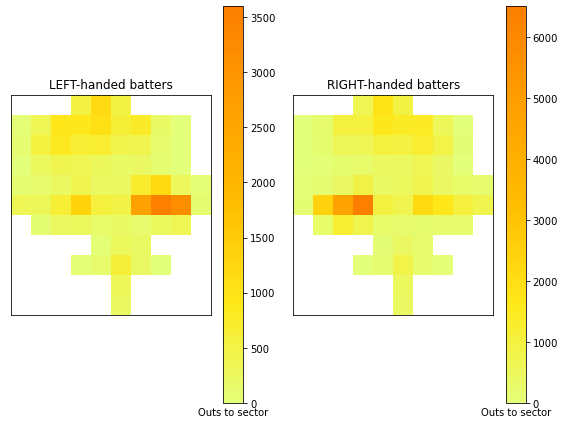

In [10]:
fig, ((ax, ax2)) = plt.subplots(1, 2, figsize=(8, 6))
cmapname = 'Wistia'
thelabelcolors = ('white', 'black')

# Replicate the above example with a different font size and colormap.
depthlabels = ['OXD', 'OD', 'O', 'OS', 'ID', 'I', 'IS', 'P', 'PC', 'C', 'BC']
oflabels = ['', '7LF', '7L', '7', '78', '8', '89', '9', '9L', '9LF']
iflabels = ['5F', '5', '56', '6', '6M', '4M', '4', '34', '3', '3F']

im, _ = heatmap(leftdata, ax=ax,
                cmap=cmapname, cbarlabel="Outs to sector")#, cbar_kw={'location': 'bottom'})
#annotate_heatmap(im, valfmt="{x:.0f}", size=7, textcolors=thelabelcolors)

ax.set_xticks([])
ax.set_yticks([])
#ax.spines[:].set_visible(False)
ax.set_title('LEFT-handed batters')

im, _ = heatmap(rightdata, ax=ax2,
                cmap=cmapname, cbarlabel="Outs to sector")#, cbar_kw={'location': 'bottom'})
#annotate_heatmap(im, valfmt="{x:.0f}", size=7, textcolors=thelabelcolors)

ax2.set_xticks([])
ax2.set_yticks([])
#ax2.spines[:].set_visible(False)
ax2.set_title('RIGHT-handed batters')

plt.tight_layout()
plt.show()
#plt.savefig('outlocations.svg'.format(cmapname), format='svg', bbox_inches='tight')
